In [13]:
import pandas as pd
import numpy as np
import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from numpy import concatenate
from math import sqrt
from sklearn.metrics import mean_squared_error

train_a = pd.read_csv('C:/Users/kari.abromitis/Desktop/Data Science/train_a_final.csv')
train_b = pd.read_csv('C:/Users/kari.abromitis/Desktop/Data Science/train_b_final.csv')
train_c = pd.read_csv('C:/Users/kari.abromitis/Desktop/Data Science/train_c_final.csv')


train_c = train_c.drop(['period','Day','Hour','Unnamed: 0','Minute_x_x','Second_x_x', 'Minute_y_x', 'Second_y_x', 'Minute_x_y',  'Second_x_y',  'Minute_y_y', 'Second_y_y'], axis=1)
train_c = train_c[['dst','bt_mean', 'density_mean', 'speed_mean', 'temp_mean', 'bt_std','density_std', 'speed_std', 'temp_std', 'smoothed_ssn']]
print(train_c)


       dst   bt_mean  density_mean  speed_mean     temp_mean    bt_std  \
0      -18  9.093684      5.234912  451.442632  49204.982456  0.742023   
1      -19  9.769828      3.975517  451.506379  22415.310345  0.074985   
2      -31  9.059828      5.128103  445.658103  34076.068966  0.490962   
3      -33  8.849464      4.716607  437.124464  27186.803571  0.242962   
4      -32  8.438103      4.426207  432.254655  18270.827586  0.134431   
...    ...       ...           ...         ...           ...       ...   
57598  -16  4.471250      2.815179  337.512321  48704.339286  0.144387   
57599  -14  4.518571      2.333929  334.182679  61596.750000  0.099625   
57600  -14  4.566034      2.309828  348.398621  34921.879310  0.133442   
57601  -15  4.715088      2.133333  343.394035  41678.245614  0.199169   
57602  -14  4.555000      2.293276  343.861897  36160.844828  0.049780   

       density_std  speed_std      temp_std  smoothed_ssn  
0         1.333061   3.408638  23104.069555        

In [14]:


# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

values = train_c
# integer encode direction
# encoder = LabelEncoder()
# values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[11,12,13,14,15,16,17,18,19]], axis=1, inplace=True)
# print(reframed.head())

print(reframed)

       var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1       0.807256   0.159300   0.077307   0.442112   0.027701   0.052170   
2       0.804989   0.171619   0.058709   0.442175   0.012619   0.005272   
3       0.777778   0.158683   0.075729   0.436447   0.019184   0.034518   
4       0.773243   0.154851   0.069653   0.428090   0.015305   0.017082   
5       0.775510   0.147356   0.065364   0.423321   0.010286   0.009452   
...          ...        ...        ...        ...        ...        ...   
57598   0.802721   0.073756   0.041096   0.337738   0.022619   0.014052   
57599   0.811791   0.075085   0.041573   0.330537   0.027419   0.010151   
57600   0.816327   0.075947   0.034466   0.327276   0.034677   0.007004   
57601   0.816327   0.076811   0.034110   0.341198   0.019660   0.009382   
57602   0.814059   0.079527   0.031504   0.336297   0.023464   0.014003   

       var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)   var1(t)  
1       0.047912   0.010407   0.0235

In [15]:
# split into train and test sets

values = reframed.values
n_train_hours = round(len(values) * 0.8)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)



(46015, 1, 10) (46015,) (11504, 1, 10) (11504,)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 300)               373200    
                                                                 
 dense_2 (Dense)             (None, 1)                 301       
                                                                 
Total params: 373,501
Trainable params: 373,501
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
480/480 - 4s - loss: 0.0512 - accuracy: 2.1732e-05 - val_loss: 0.0881 - val_accuracy: 0.0000e+00 - 4s/epoch - 9ms/step
Epoch 2/30
480/480 - 3s - loss: 0.0198 - accuracy: 4.3464e-05 - val_loss: 0.0559 - val_accuracy: 0.0000e+00 - 3s/epoch - 6ms/step
Epoch 3/30
480/480 - 4s - loss: 0.0173 - accuracy: 4.3464e-05 - val_loss: 0.0382 - val_accuracy: 0.0000e+00 - 4s/epoch - 8ms/step
Epoch 4/30
480/480 - 4s - loss: 0.0138 - accuracy: 4.3

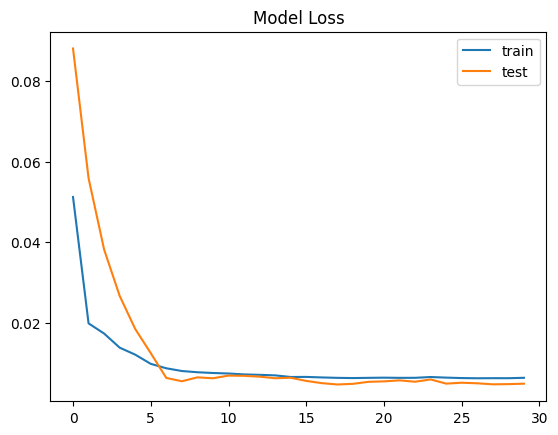

In [16]:

# design network
model = Sequential()
model.add(LSTM(300, input_shape=(train_X.shape[1], train_X.shape[2])))

model.add(Dense(1))
model.compile(loss='mae', optimizer='adam',metrics=['accuracy'])
model.summary()

# model.summary()
# fit network
history = model.fit(train_X, train_y, epochs=30, batch_size=96, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title("Model Loss")
plt.legend()
plt.show()



In [17]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

360/360 [==============================] - 1s 2ms/step
Test RMSE: 3.015


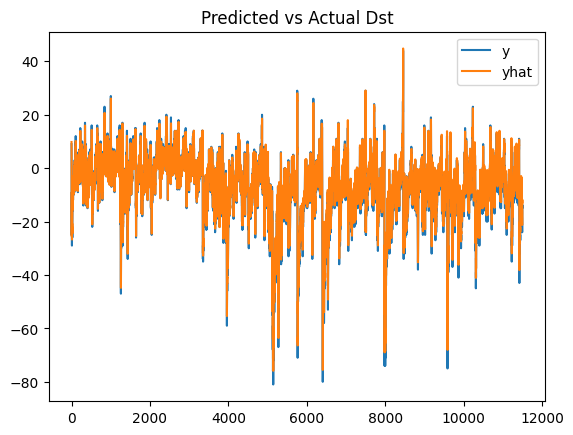

In [18]:
# pyplot.plot(inv_y, inv_yhat)
plt.plot(inv_y, label='y')
plt.plot(inv_yhat, label='yhat')
plt.legend()
plt.title("Predicted vs Actual Dst")
plt.show()

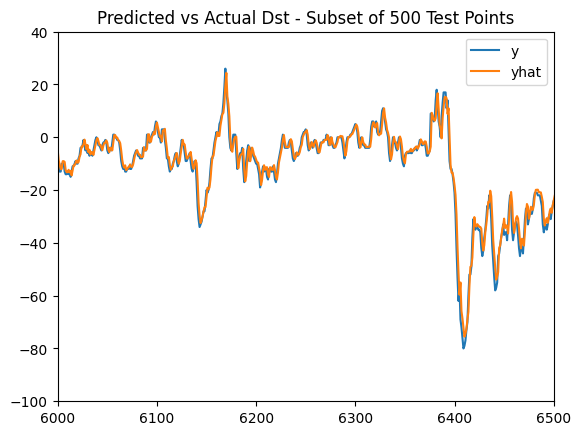

In [25]:
plt.plot(inv_y, label='y')
plt.plot(inv_yhat, label='yhat')
plt.title("Predicted vs Actual Dst - Subset of 500 Test Points")
plt.xlim([6000, 6500])
plt.ylim([-100, 40])
plt.legend()
plt.show()
